In [1]:
%load_ext autoreload
%autoreload 2
import os
#os.environ["CUDA_VISIBLE_DEVICES"]="0"

import pandas as pd
import numpy as np
from tqdm import tqdm
from pathlib import Path

import torch
import torch.nn as nn
import torch.nn.parallel
import torch.utils.data
from torch.autograd import Variable
import numpy as np
import torch.nn.functional as F

from fastai import *
from fastai.basic_train import *
from fastai.basic_data import *
from fastai.data_block import *
from fastai.torch_core import *
from fastai.train import *
from fastai.callback import *
from fastai.callbacks import *
from fastai.distributed import *
from fastai.layers import *

In [2]:
fname_ext = lambda fname,ext: f'{str(fname)[:-4]}{ext}{str(fname)[-4:]}'
def preprocess(fname, type_index=None, ext=''):
    t  = pd.read_csv(fname_ext(fname,ext))
    s  = pd.read_csv('structures.csv')
    
    has_y = 'scalar_coupling_constant' in t.columns

    if has_y:
        # atom-atom level
        # molecule_name,atom_index_0,atom_index_1,type,fc,sd,pso,dso
        scalar_couplings = pd.read_csv(f'scalar_coupling_contributions{ext}.csv') # fc,sd,pso,dso

        # atom level
        # molecule_name,atom_index,XX,YX,ZX,XY,YY,ZY,XZ,YZ,ZZ
        magnetic_shielding = pd.read_csv('magnetic_shielding_tensors.csv')
        # molecule_name,atom_index,mulliken_charge
        mulliken_charges = pd.read_csv('mulliken_charges.csv')

        # molecule level
        # molecule_name,X,Y,Z
        dipole_moments = pd.read_csv('dipole_moments.csv')
        # molecule_name,potential_energy
        potential_energy = pd.read_csv('potential_energy.csv')

    t['molecule_index'] = pd.factorize(t['molecule_name'])[0] + t['id'].min()
    # make sure we use the same indexes in train/test (test needs to provide type_index)
    if type_index is not None:
        t['type_index'] = pd.factorize(pd.concat([pd.Series(type_index),t['type']]))[0][len(type_index):]
    else:
        t['type_index'] = pd.factorize(t['type'])[0]
    s = pd.concat([s,pd.get_dummies(s['atom'])], axis=1)

    max_items = len(t.groupby(['molecule_name', 'atom_index_0']))# if has_y else 422550
    max_atoms = int(s.atom_index.max() + 1)

    if has_y:
        contributions = ['fc','sd','pso','dso']
        magnetic_tensors = ['XX','YX','ZX','XY','YY','ZY','XZ','YZ','ZZ']
        XYZ = ['X','Y','Z']
    xyz = ['x', 'y', 'z']
    a_hot = ['C','F','H','N','O']
    
    x_xyz   = np.zeros((max_items,len(xyz),  max_atoms), dtype=np.float32)
    x_a_hot = np.zeros((max_items,len(a_hot),max_atoms), dtype=np.float32)
    x_type  = np.zeros((max_items,1,         max_atoms), dtype=np.float32)

    if has_y:
        y_scalar   = np.zeros((max_items,len(contributions)   ,max_atoms), dtype=np.float32)
        y_magnetic = np.zeros((max_items,len(magnetic_tensors),max_atoms), dtype=np.float32)
        y_mulliken = np.zeros((max_items,1                    ,max_atoms), dtype=np.float32)

        y_dipole   = np.zeros((max_items,len(XYZ)), dtype=np.float32)
        y_potential= np.zeros((max_items,1              ), dtype=np.float32)

        y_magnetic[...] = np.nan
        y_mulliken[...] = np.nan
    else:
        xt_ids = np.zeros((max_items, max_atoms), dtype=np.int32)


    m = np.zeros((max_items,), dtype=np.int32)
    i = j = 0
    
    for (m_name, m_index) ,m_group in tqdm(t.groupby(['molecule_name', 'molecule_index'])):
        ss = s[s.molecule_name==m_name]
        n_atoms = len(ss)
        if has_y:
            magnetic = magnetic_shielding[
                    (magnetic_shielding['molecule_name']==m_name)][magnetic_tensors].values.T

            mulliken = mulliken_charges[
                    (mulliken_charges['molecule_name']==m_name)]['mulliken_charge'].values.T

            scs = scalar_couplings[scalar_couplings['molecule_name']==m_name]
            
            y_dipole[j,:]= dipole_moments[dipole_moments['molecule_name']==m_name][XYZ].values
            y_potential[j,:]=potential_energy[
                potential_energy['molecule_name']==m_name]['potential_energy'].values
        
        for a_name,a_group in m_group.groupby('atom_index_0'):
            
            ref_a = ss[ss['atom_index']==a_name]
            
            x_xyz[i] = 0.
            x_a_hot[i] = ref_a[a_hot].values.T
            x_type[i] = -1

            x_xyz[i,:,:n_atoms] = (ss[xyz].values-ref_a[xyz].values).T  # xyz 
            x_a_hot[i,:,:n_atoms] = ss[a_hot].T                  # a_hot
            x_type[i,0,a_group['atom_index_1']] = a_group['type_index']  # type 
            
            if has_y:
                y_scalar[i,:,a_group['atom_index_1']] = scs[scs['atom_index_0']==a_name][contributions]
                y_magnetic[i,:,:n_atoms] = magnetic
                y_mulliken[i,:,:n_atoms] = mulliken
            else:
                xt_ids[i,a_group['atom_index_1']] = a_group['id']  

            m[i] = m_index
            i+=1
        j += 1
    assert i == max_items
    print(i,max_items)
    if has_y:
        return x_xyz,x_a_hot,x_type, m , y_scalar, y_magnetic, y_mulliken, y_dipole, y_potential
    else:
        return x_xyz,x_a_hot,x_type, m, xt_ids

Define where you want to use original training set '' or extended ''

In [3]:
ext = '_ext' # or ''

Load preprocessed or preprocess and save for later

In [4]:
train_fname = Path('train.npz')
type_index = pd.factorize(pd.read_csv(train_fname.with_suffix('.csv'))['type'])[1]

try:
    npzfile = np.load(fname_ext(train_fname, ext))
    x_xyz = npzfile['x_xyz']
    x_a_hot = npzfile['x_a_hot']
    x_type = npzfile['x_type']
    y_scalar = npzfile['y_scalar']
    y_magnetic = npzfile['y_magnetic']
    y_mulliken = npzfile['y_mulliken']
    y_dipole = npzfile['y_dipole']
    y_potential = npzfile['y_potential']
    m = npzfile['m']
    max_items, max_atoms = x_xyz.shape[0], x_xyz.shape[-1]
except:
    x_xyz,x_a_hot,x_type, m , y_scalar, y_magnetic, y_mulliken, y_dipole, y_potential = \
        preprocess(train_fname.with_suffix('.csv'), type_index=type_index, ext=ext)
    np.savez(fname_ext(train_fname, ext), 
             x_xyz=x_xyz,
             x_a_hot=x_a_hot,
             x_type=x_type,
             y_scalar=y_scalar,
             y_magnetic=y_magnetic,
             y_mulliken=y_mulliken,
             y_dipole=y_dipole,
             y_potential=y_potential,
             m=m)
n_types = int(x_type[~np.isnan(x_type)].max() + 1)

In [5]:
use_memmap = True
try:
    load_fn = np.load if not use_memmap else partial(np.lib.format.open_memmap, mode='r')
    x_coulombmat = load_fn(f'x_coulombmat32{ext}.npy')
except:
    x_coulombmat = np.load(f'x_coulombmat{ext}.npy', allow_pickle=True)
    x_coulombmat = np.array(x_coulombmat.tolist()).astype(np.float32)
    np.save(f'x_coulombmat32{ext}.npy', x_coulombmat)

In [6]:
test_fname = Path('test.npz')
try:
    npzfile = np.load(fname_ext(test_fname, ext))
    xt_xyz = npzfile['x_xyz']
    xt_a_hot = npzfile['x_a_hot']
    xt_type = npzfile['x_type']
    mt = npzfile['m']
    xt_ids = npzfile['x_ids']
except:
    xt_xyz,xt_a_hot,xt_type,mt,xt_ids = \
        preprocess(test_fname.with_suffix('.csv'), type_index=type_index,ext=ext)
    np.savez(fname_ext('_'+test_fname, ext), 
             x_xyz=xt_xyz,
             x_a_hot=xt_a_hot,
             x_type=xt_type,
             m=mt,
             x_ids=xt_ids)

In [7]:
[v.shape for v in [x_xyz,x_a_hot,x_type, y_scalar, y_magnetic, y_mulliken, y_dipole, y_potential, m]]

[(1405126, 3, 29),
 (1405126, 5, 29),
 (1405126, 1, 29),
 (1405126, 4, 29),
 (1405126, 9, 29),
 (1405126, 1, 29),
 (1405126, 3),
 (1405126, 1),
 (1405126,)]

In [8]:
# TODO: Do norm in FASTAI instead of here
# TOCHECK: Filter only valid atoms (otherwise repeated atoms may skew stats)
#xyz_mean, xyz_std = x_xyz.mean(axis=(0,2), keepdims=True),  x_xyz.std(axis=(0,2), keepdims=True)
#x_xyz  = (x_xyz  - xyz_mean) / xyz_std
#xt_xyz = (xt_xyz - xyz_mean) / xyz_std

In [9]:
[v.shape for v in [xt_xyz,xt_a_hot,xt_type,xt_ids, mt]]

[(756113, 3, 29), (756113, 5, 29), (756113, 1, 29), (756113, 29), (756113,)]

Fastai classes (this should should be done into its own `application` but who has time?

In [10]:
class MoleculeItem(ItemBase):
    def __init__(self,i,xyz,a_hot,type,coulomb): 
        self.i,self.xyz,self.a_ahot,self.type,self.coulomb = i,xyz,a_hot,type,coulomb
        self.data = [torch.cat([Tensor(xyz), Tensor(self.a_ahot),Tensor(self.type)], dim=0), 
                     Tensor(coulomb)]
    def __str__(self):
        # TODO: count n_atoms correctly. 
        n_atoms = np.count_nonzero(np.sum(np.absolute(self.xyz), axis=0))+1
        n_couplings = np.sum((self.type!=-1))
        return f'{self.i} {n_atoms} atoms {n_couplings} couplings'
    
    def apply_tfms(self, tfms:Collection, **kwargs):
        x = self.clone()
        #print(tfms)
        for t in tfms:
            if t: x.data = t(x.data)
        return x
    
    def clone(self):
        return self.__class__(self.i,self.xyz,self.a_ahot,self.type,self.coulomb)
    
class ScalarCouplingItem(ItemBase):
    def __init__(self,scalar,magnetic,mulliken,dipole,potential,**kwargs): 
        self.scalar,self.magnetic,self.mulliken,self.dipole,self.potential = \
            scalar,magnetic,mulliken,dipole,potential
        #self.data = Tensor(np.sum(scalar, axis=0))
        self.data = (Tensor(scalar), Tensor(magnetic), Tensor(dipole), Tensor(potential))
    def __str__(self):
        res, spacer, n_couplings = '', '', 0
        for s in self.data[0].sum(dim=0):
            if s==0.: spacer = ' * '
            else: 
                res += f'{spacer}{s:.4f}'
                spacer = ' '
                n_couplings +=1
        return f'{n_couplings}: {res}'
    def __hash__(self): return hash(str(self))

In [11]:
class LMAEMaskedLoss(Module):
    def __init__(self,input_transform_w=0,feature_transform_w=1e-3,
                 contrib_w=1e-1, magnetic_w=1e-4, dipole_w=1e-1, potential_w=5e-5, 
                 types_w = [1]*n_types, return_all=False, proxy_log=torch.log):
        self.input_transform_w,self.feature_transform_w = input_transform_w,feature_transform_w
        self.contrib_w,self.magnetic_w,self.dipole_w,self.potential_w = contrib_w,magnetic_w,dipole_w,potential_w
        self.types_w = types_w
        self.return_all = return_all
        self.proxy_log = proxy_log
    
    def forward(self, input_outputs, t_scalar, t_magnetic, t_dipole, t_potential):    
        input, p_scalar, p_magnetic, p_dipole, p_potential, trans, trans_feat = input_outputs
        loss = 0.
        n = 0
        j_loss = [0] * n_types
        for type in range(n_types):
            mask = (input[:,8,:] == type)
            if mask.sum() > 0:
                _output,_target = p_scalar.transpose(1,2)[mask], t_scalar.transpose(1,2)[mask] # scalars at the end
                # LMAE scalar
                s_loss = self.proxy_log((_output.sum(dim=-1) - _target.sum(dim=-1)).abs().mean()+1e-9)
                loss += self.types_w[type] * s_loss
                j_loss[type] += s_loss
                # LMAE scalar contributions
                for i_contrib in range(_output.shape[-1]):
                    loss += self.contrib_w * \
                        self.proxy_log((_output[...,i_contrib] - _target[...,i_contrib]).abs().mean()+1e-9)
                n+=1
        loss /= n
        if self.input_transform_w   > 0: loss += feature_transform_regularizer(trans)*self.input_transform_w
        if self.feature_transform_w > 0: loss += feature_transform_regularizer(trans_feat)*self.feature_transform_w

        if self.magnetic_w > 0:
            mask = ~torch.isnan(t_magnetic)
            loss += self.magnetic_w * MSELossFlat()(p_magnetic[mask], t_magnetic[mask])
            
        if self.dipole_w    > 0: loss += self.dipole_w    * MSELossFlat()(p_dipole,    t_dipole)
        if self.potential_w > 0: loss += self.potential_w * MSELossFlat()(p_potential, t_potential)

        return loss if not self.return_all else (loss, *j_loss)

In [12]:
class ScalarCouplingList(ItemList):
    def __init__(self, items:Iterator, **kwargs):
        super().__init__(items, **kwargs)
        self.c = 4
        self.loss_func = LMAEMaskedLoss

    def get(self, i):
        o = super().get(i)
        return ScalarCouplingItem(*o)

    def reconstruct(self,t): return 0; # TODO for viz !!!! ScalarCouplingItem(t.numpy())

Quaterions allow us to rotate 3d points randoming with a nice uniform distribution of 3 numbers hece we use them, however it's still to be seen if are useful here

In [13]:
#https://github.com/facebookresearch/QuaterNet/blob/master/common/quaternion.py
def qrot(q, v):
    """
    Rotate vector(s) v about the rotation described by quaternion(s) q.
    Expects a tensor of shape (*, 4) for q and a tensor of shape (*, 3) for v,
    where * denotes any number of dimensions.
    Returns a tensor of shape (*, 3).
    """
    assert q.shape[-1] == 4
    assert v.shape[-1] == 3
    assert q.shape[:-1] == v.shape[:-1]
    
    
    original_shape = list(v.shape)
    q = q.view(-1, 4)
    v = v.view(-1, 3)
    
    qvec = q[:, 1:]
    uv = torch.cross(qvec, v, dim=1)
    uuv = torch.cross(qvec, uv, dim=1)
    return (v + 2 * (q[:, :1] * uv + uuv)).view(original_shape)

def random_rotation(data):
    x_xyz = data[0][:3].transpose(0,1)
    r = torch.rand(3)
    sq1_v1,sqv1,v2_2pi,v3_2pi = torch.sqrt(1-r[:1]),torch.sqrt(r[:1]),2*math.pi*r[1:2],2*math.pi*r[2:3]
    q = torch.cat([sq1_v1*torch.sin(v2_2pi), sq1_v1*torch.cos(v2_2pi), 
                   sqv1  *torch.sin(v3_2pi), sqv1  *torch.cos(v3_2pi)], dim=0).unsqueeze(0)
    x_xyz = qrot(q.expand(x_xyz.shape[0],-1), x_xyz).squeeze(0).transpose(0,1)
    return (torch.cat((x_xyz, data[0][3:]), dim=0), data[1])

def smooth_atom_one_hot(data):
    r = torch.rand(5,5)
    r[:,0] = r[:,0]*.2 + 0.8
    s = 1 - r[:,0]
    rs = r[:,1:].sum(dim=1,keepdim=True)
    r[:,1:] *= s.unsqueeze(-1)/rs
    for i in range(5):
        r[i] = r[i].roll(i,dims=0)
    a_hot = data[0][3:-1].argmax(dim=0)
    data[0][3:-1] = r[a_hot].transpose(0,1)
    return data

Build `data` bunch etc. for fastai

In [14]:
data = ItemList(items=(MoleculeItem(i,*v) for i,v in enumerate(zip(x_xyz,x_a_hot,x_type, x_coulombmat))),
                label_cls=ScalarCouplingItem)

In [15]:
from sklearn.model_selection import train_test_split
_, idx_valid_split = train_test_split(range(m.max()+1), test_size=0.1, random_state=13)
idx_valid_split = np.argwhere(np.isin(m, idx_valid_split)).flatten()

In [16]:
data = data.split_by_idx(idx_valid_split)

In [17]:
data = data.label_from_func(
    func=lambda o: (y_scalar[o.i], y_magnetic[o.i], y_mulliken[o.i], y_dipole[o.i], y_potential[o.i]),
    label_cls=ScalarCouplingList)

Need to find a way of adding test right before inference but Im getting conflics with TTA if setting transforms later, hence this hack.

In [18]:
try:
    xt_coulombmat = load_fn(f'xt_coulombmat32{ext}.npy')
except:
    xt_coulombmat = np.load(f'xt_coulombmat{ext}.npy', allow_pickle=True)
    xt_coulombmat = np.array(xt_coulombmat.tolist()).astype(np.float32)
    np.save(f'xt_coulombmat32{ext}.npy', xt_coulombmat)

In [20]:
#data = data.transform(([random_rotation, smooth_atom_one_hot], [random_rotation, smooth_atom_one_hot]))

# IMPORTANT IF/WHEN DOING TTA ch

data = data.transform(([random_rotation, smooth_atom_one_hot], None))

In [ ]:
data.add_test(ItemList(items=(MoleculeItem(i,*v) for i,v in enumerate(zip(xt_xyz,xt_a_hot,xt_type,xt_coulombmat)))),
              tmfs = [random_rotation, smooth_atom_one_hot])

In [21]:
data=data.databunch()

Whole model here, self-coained (needs some cleanup)

In [22]:
# TODO REFACTOR
class Quaternion(Module):
    def __init__(self, in_channels = 3):
        self.conv1 = torch.nn.Conv1d(in_channels, 64, 1)
        self.conv2 = torch.nn.Conv1d(64, 128, 1)
        self.conv3 = torch.nn.Conv1d(128, 1024, 1)
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 3)
        self.relu = nn.ReLU()

        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(1024)
        self.bn4 = nn.BatchNorm1d(512)
        self.bn5 = nn.BatchNorm1d(256)

    def forward(self, x):
        batchsize = x.size()[0]
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = torch.max(x, 2, keepdim=True)[0]
        x = x.view(-1, 1024)

        x = F.relu(self.bn4(self.fc1(x)))
        x = F.relu(self.bn5(self.fc2(x)))
        x = torch.sigmoid(self.fc3(x))
        
        #http://planning.cs.uiuc.edu/node198.html
        sq1_v1,sqv1,v2_2pi,v3_2pi = torch.sqrt(1-x[:,:1]),torch.sqrt(x[:,:1]),2*math.pi*x[:,1:2],2*math.pi*x[:,2:3]
        q = torch.cat([sq1_v1*torch.sin(v2_2pi), sq1_v1*torch.cos(v2_2pi), 
                       sqv1  *torch.sin(v3_2pi), sqv1  *torch.cos(v3_2pi)], dim=1)
        return q
    
# https://github.com/eladhoffer/fix_your_classifier/blob/master/fixed_proj.py
class LinearProjection(Module):

    def __init__(self, input_size, output_size, bias=True, init_scale=10):
        if init_scale is not None:
            self.weight = nn.Parameter(torch.Tensor(1).fill_(init_scale))
        if bias:
            self.bias = nn.Parameter(torch.Tensor(output_size).fill_(0))
        self.proj = Variable(torch.Tensor(
            output_size, input_size), requires_grad=False)
        torch.manual_seed(123)
        nn.init.orthogonal_(self.proj)

    def forward(self, x):
        w = self.proj.type_as(x)
        x = x / x.norm(2, -1, keepdim=True)
        out = nn.functional.linear(x, w)
        if hasattr(self, 'weight'): out = out * self.weight
        if hasattr(self, 'bias'):   out = out + self.bias.view(1, -1)
        return out

# from https://github.com/fxia22/pointnet.pytorch/blob/master/pointnet/model.py
class STNkd(Module):
    def __init__(self, pools, channels, add_eye, last_fc=nn.Linear):
        k, c_filters, fc_filters = channels[0][0], channels[0][1:], channels[1]
        self.conv1 = torch.nn.Conv1d(k, c_filters[0], 1)
        self.conv2 = torch.nn.Conv1d(c_filters[0], c_filters[1], 1)
        self.conv3 = torch.nn.Conv1d(c_filters[1], c_filters[2], 1)
        self.fc1 = nn.Linear(c_filters[2]*len(pools), fc_filters[0])
        self.fc2 = nn.Linear(fc_filters[0], fc_filters[1])
        self.fc3 = last_fc(fc_filters[1], k*k)
        # TODO REFACTOR
        self.relu = nn.ReLU()
        self.bn1 = nn.BatchNorm1d(c_filters[0])
        self.bn2 = nn.BatchNorm1d(c_filters[1])
        self.bn3 = nn.BatchNorm1d(c_filters[2])
        self.bn4 = nn.BatchNorm1d(fc_filters[0])
        self.bn5 = nn.BatchNorm1d(fc_filters[1])
        self.pools = [pool(1) for pool in pools]

        self.k = k
        self.add_eye = add_eye

    def forward(self, x):
        batchsize = x.size()[0]
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = torch.cat([pool(x).squeeze(-1) for pool in self.pools], dim=-1)    
        x = F.relu(self.bn4(self.fc1(x)))
        x = F.relu(self.bn5(self.fc2(x)))
        x = self.fc3(x).view(-1, self.k, self.k)
        if self.add_eye: x += torch.eye(self.k, dtype=x.dtype, device=x.device).unsqueeze(0)
        return x

class PointNetfeat(Module):
    def __init__(self, pools, C, quaternion_transform,
                 input_transform, feature_transform, add_eye=True):
        self.qrot = Quaternion() if quaternion_transform else None
        self.stn = STNkd(pools, channels = input_transform, add_eye=add_eye) if input_transform else None        
        self.convs = nn.ModuleList([nn.Sequential(
            nn.Conv1d(C[i], C[i+1], 1), nn.BatchNorm1d(C[i+1]), nn.ReLU(), ) for i in range(len(C)-1)])
        self.fstn = STNkd(pools, channels = feature_transform, add_eye=add_eye, 
                         last_fc = nn.Linear) if feature_transform else None
        self.pools = [pool(1) for pool in pools]

    def forward(self, x):
        batchsize, _, n_pts = x.shape
        if self.qrot is not None:
            x_xyz = x[:,:3,...]
            q = self.qrot(x_xyz).unsqueeze(1).expand(-1,n_pts,-1).contiguous()
            x_xyz = x_xyz.transpose(1,2).contiguous()
            x[:,:3,:] = qrot(q,x_xyz).transpose(2,1)
        if self.stn is not None: # TODO add xyz_
            x_xyz = x[:,:3,...].clone()
            trans = self.stn(x_xyz)
            x[:,:3,:] = torch.bmm(trans, x_xyz)
        else:
            trans = torch.eye(1, dtype=x.dtype, device=x.device).view(1,1).expand((batchsize,-1))
        for conv in self.convs[:2]:
            x = conv(x)

        if self.fstn is not None:
            trans_feat = self.fstn(x)
            x = torch.bmm(trans_feat, x)
        else:
            trans_feat = torch.eye(1, dtype=x.dtype, device=x.device).view(1,1).expand((batchsize,-1))

        pointfeat = x
        for conv in self.convs[2:]:
            x = conv(x)
        x = torch.cat([pool(x).squeeze(-1) for pool in self.pools], dim=-1)    
        return pointfeat, x, trans, trans_feat
    
class PointNetDenseReg(Module):
    def __init__(self, feat_channels, seg_channels, 
                 quaternion_transform, input_transform, feature_transform, add_eye, 
                 pools = [nn.AdaptiveMaxPool1d], dropout_rate = 0.):
        self.feat = PointNetfeat(pools,
                                 C = feat_channels,
                                 quaternion_transform = quaternion_transform,
                                 input_transform = input_transform, 
                                 feature_transform=feature_transform,
                                 add_eye=add_eye)
        #self.feat_c = PointNetfeat(pools,
        #                         C = feat_channels,
        #                         quaternion_transform = quaternion_transform,
        #                         input_transform = input_transform, 
        #                         feature_transform=feature_transform,
        #                         add_eye=add_eye)
        C = seg_channels
        
        C.insert(0, 2*feat_channels[-1]*len(pools) + feat_channels[1])        
        
        self.seg_convs = nn.ModuleList([nn.Sequential(
            nn.Conv1d(C[i], C[i+1], 1), nn.BatchNorm1d(C[i+1]), nn.ReLU(),) for i in range(len(C)-1)])
    
        coulomb_C = [feat_channels[2],128,1024]
        
        self.coulomb_convs = nn.ModuleList([nn.Sequential(
            nn.Conv1d(coulomb_C[i], coulomb_C[i+1], 1), nn.BatchNorm1d(coulomb_C[i+1]), nn.ReLU(),) 
                                          for i in range(len(coulomb_C)-1)])

        self.dropout = nn.Dropout(p=dropout_rate) if dropout_rate > 0. else None
        self.pools = [pool(1) for pool in pools]
        
        self.scalar    = nn.Conv1d(C[-1], 4, 1)
        self.magnetic  = nn.Conv1d(C[-1], 9, 1)
        self.dipole    = nn.Linear(feat_channels[-1], 3)
        self.potential = nn.Linear(feat_channels[-1], 1)
        
    def forward(self, x, coulomb):
        batchsize, _, n_pts = x.shape
        pointfeat, globalfeat, trans, trans_feat = self.feat(x)
        x_c = torch.matmul(pointfeat, coulomb)
        for coulomb_conv in self.coulomb_convs[:3]:
            x_c = coulomb_conv(x_c)
        x_c = torch.cat([pool(x_c) for pool in self.pools], dim=-1)   
        for coulomb_conv in self.coulomb_convs[3:]:
            x_c = coulomb_conv(x_c)
        seg_x = torch.cat([globalfeat.unsqueeze(-1).expand(-1, -1, n_pts), 
                       pointfeat,
                       x_c.expand(-1, -1, n_pts)], 1)
        
        for seg_conv in self.seg_convs:
            seg_x = seg_conv(seg_x)
            if self.dropout is not None: seg_x = self.dropout(seg_x)
            
        scalar    = self.scalar(seg_x)
        magnetic  = self.magnetic(seg_x) 
        dipole    = self.dipole(globalfeat)
        potential = self.potential(globalfeat)

        return x,scalar,magnetic,dipole,potential, trans,trans_feat

def feature_transform_regularizer(trans): 
    batchsize,d  = trans.shape[0], trans.shape[1]
    I = torch.eye(d, dtype=trans.dtype, device=trans.device).unsqueeze(0)
    loss = torch.mean(torch.norm(torch.bmm(trans, trans.transpose(2,1)) - I, dim=(1,2)))
    return loss

This callback allows to insert multiple stateful (not averaged) metrics in one pass. Addditionally we could add metrics for train if we want to.

In [23]:
class LMAEMetric(LearnerCallback):
    _order=-20 # Needs to run before the recorder
    def __init__(self, learn):
        super().__init__(learn)
        self.metric = LMAEMaskedLoss(0.,0.,0.,0.,0.,0.,return_all=True)

    def on_train_begin(self, **kwargs):
        self.learn.recorder.add_metric_names(['👉🏻LMAE👈🏻'] + [f'lmae{i}' for i in range(n_types)])
            
    def on_batch_end(self, train, last_output, last_target, **kwargs):
        if not train:
            if self.preds is None:
                self.targs, self.preds = listify(last_target), listify(last_output)
            else:
                for i,(o,t) in enumerate(zip(last_output, last_target)):
                    self.preds[i] = torch.cat([self.preds[i], o], dim=0)
                    self.targs[i] = torch.cat([self.targs[i], t], dim=0)
        
    def on_epoch_begin(self, **kwargs):
        self.targs, self.preds = None, None

    def on_epoch_end(self, last_metrics, **kwargs):
        return add_metrics(last_metrics, self.metric.forward(self.preds, *self.targs)) \
            if self.preds is not None else None

Model instantiation: where's all your TPUs/GPUs when you need a decent hyperparam sweep?

In [24]:
net, learner = None,None
gc.collect()
torch.cuda.empty_cache()
net = PointNetDenseReg(feat_channels = [9,64,64,128,1024],
                       seg_channels  = [512,256,128*2],
                       quaternion_transform=False, 
                       input_transform=[[3, 64,128,1024], [512,256]], 
                       feature_transform=[[64, 64,128,1024], [512,256]],
                       add_eye=True,
                       dropout_rate=0.)

learner = Learner(data,net, loss_func=LMAEMaskedLoss(magnetic_w=5e-5, dipole_w=1e-2, potential_w=2.5e-5),)

learner.callbacks.append(LMAEMetric(learner))

In [25]:
sub_fname = "loss-3.9978val-1.9089" # uncomment or set None to skip loading trained net

In [26]:
try:
    print(f"Attempting to load: {sub_fname}... ", end="")
    learner.load(sub_fname, strict=False,with_opt=False)
    print("Loaded")
except:
    print("NOT loaded!")

Attempting to load: loss-3.9978val-1.9089... 

/home/antor/miniconda3/lib/python3.6/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type LMAEMaskedLoss. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/antor/miniconda3/lib/python3.6/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type PointNetDenseReg. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/antor/miniconda3/lib/python3.6/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type PointNetfeat. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/antor/miniconda3/lib/python3.6/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type STNkd. It won't be checked for correctness upon loading.
  "type " + o

NOT loaded!


In [27]:
# neural weight manual transplant 
if False:
    #load old model and transplant weights/bias
    #x= torch.load('models/loss-4.4237val-1.9855.pth')
    for name,child in learner.model.named_children():
        print("CHILD: ",name)
        if not (name in ['scalar', 'seg_convs', 'magnetic']):
            print("FREEZING")
            for param in child.parameters(): param.requires_grad = False
        else:
            for name,param in child.named_parameters(): 
                param.requires_grad = True
                #if name == 'weight': param.data = x['model']['seg_convs.3.weight']
                #if name == 'bias'  : param.data = x['model']['seg_convs.3.bias']


In [28]:
learner.summary()

PointNetDenseReg
Layer (type)         Output Shape         Param #    Trainable 
Conv1d               [64, 29]             256        True      
______________________________________________________________________
Conv1d               [128, 29]            8,320      True      
______________________________________________________________________
Conv1d               [1024, 29]           132,096    True      
______________________________________________________________________
Linear               [512]                524,800    True      
______________________________________________________________________
Linear               [256]                131,328    True      
______________________________________________________________________
Linear               [9]                  2,313      True      
______________________________________________________________________
BatchNorm1d          [64, 29]             128        True      
_____________________________________________

In [29]:
learner.model

PointNetDenseReg(
  (feat): PointNetfeat(
    (stn): STNkd(
      (conv1): Conv1d(3, 64, kernel_size=(1,), stride=(1,))
      (conv2): Conv1d(64, 128, kernel_size=(1,), stride=(1,))
      (conv3): Conv1d(128, 1024, kernel_size=(1,), stride=(1,))
      (fc1): Linear(in_features=1024, out_features=512, bias=True)
      (fc2): Linear(in_features=512, out_features=256, bias=True)
      (fc3): Linear(in_features=256, out_features=9, bias=True)
      (relu): ReLU()
      (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn3): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn4): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn5): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (convs): ModuleList(
      (0): Sequential(
        (0):

In [30]:
learner = learner.to_parallel()#.to_fp16() b/c it NaNs loss (probably would need to change fp16 settings)
data.batch_size = int(4096*1.7)

Real loss func. Need to test different auxiliary tasks weights: `magnetic_w`, `dipole_w`, `potential`, weights of indivial `lmae`s: `types_w` and maybe `input_transform_w` and `feature_transform_w`

In [31]:
learner.loss_func = LMAEMaskedLoss(feature_transform_w=0, magnetic_w=1e-4, dipole_w=0, potential_w=5e-5, 
                                  types_w = [1] + [1] * (n_types-1))

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-03
Min loss divided by 10: 1.20E-02


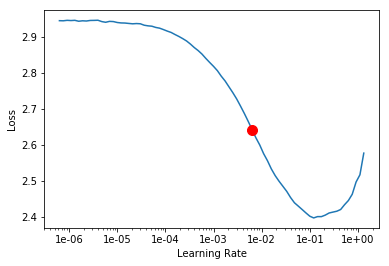

In [32]:
learner.lr_find()
learner.recorder.plot(suggestion=True)

In [34]:
learner.fit_one_cycle(600, 1.2e-2)#, moms=(0.75,0.70))

epoch,train_loss,valid_loss,👉🏻LMAE👈🏻,lmae0,lmae1,lmae2,lmae3,lmae4,lmae5,lmae6,lmae7,time
0,-0.354343,-0.455301,-0.222663,4.235791,-1.670530,2.480892,-1.825399,-0.752413,-1.672117,-0.658777,-1.918751,01:42
1,-0.937894,-1.008139,-0.683678,4.119551,-1.780618,-0.579237,-1.917310,-0.833622,-1.765919,-0.729209,-1.983060,01:42
2,-1.185910,-1.207649,-0.736431,4.050996,-1.774397,-0.686351,-1.952008,-0.901358,-1.798085,-0.774503,-2.055739,01:42
3,-1.375501,-1.356588,-0.783079,3.982387,-1.681315,-0.875292,-2.021747,-0.934391,-1.840404,-0.807153,-2.086718,01:42
4,-1.514529,-1.541137,-0.855038,3.911590,-1.886201,-0.990326,-2.068850,-0.971547,-1.870880,-0.833827,-2.130263,01:42
5,-1.637992,-1.612047,-0.864723,3.849620,-1.802145,-0.955552,-2.099484,-1.004029,-1.896814,-0.858159,-2.151222,01:42
6,-1.727223,-1.719713,-0.905350,3.768528,-1.894459,-1.012697,-2.122328,-1.022079,-1.903852,-0.874568,-2.181346,01:43
7,-1.804733,-1.767689,-0.930971,3.663536,-1.887888,-1.040150,-2.129732,-1.045766,-1.916679,-0.890004,-2.201086,01:42
8,-1.868323,-1.841880,-0.964512,3.527061,-1.915284,-1.071843,-2.154187,-1.059821,-1.928818,-0.900995,-2.212209,01:42
9,-1.943874,-1.897700,-1.021029,3.301918,-1.956833,-1.142133,-2.178807,-1.073236,-1.963591,-0.918557,-2.236989,01:42


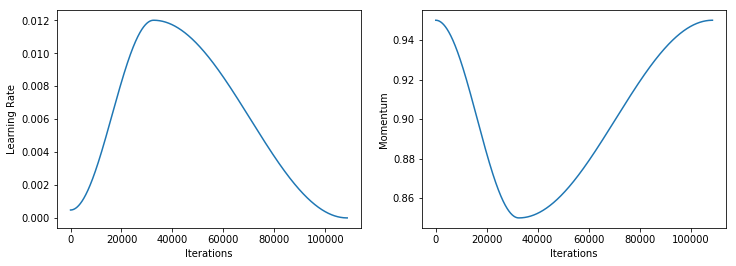

In [35]:
learner.recorder.plot_lr(show_moms=True)

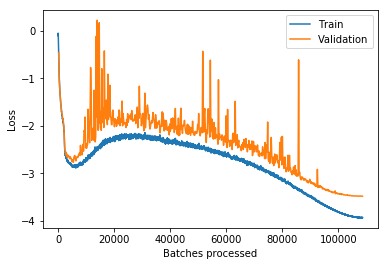

In [37]:
learner.recorder.plot_losses()

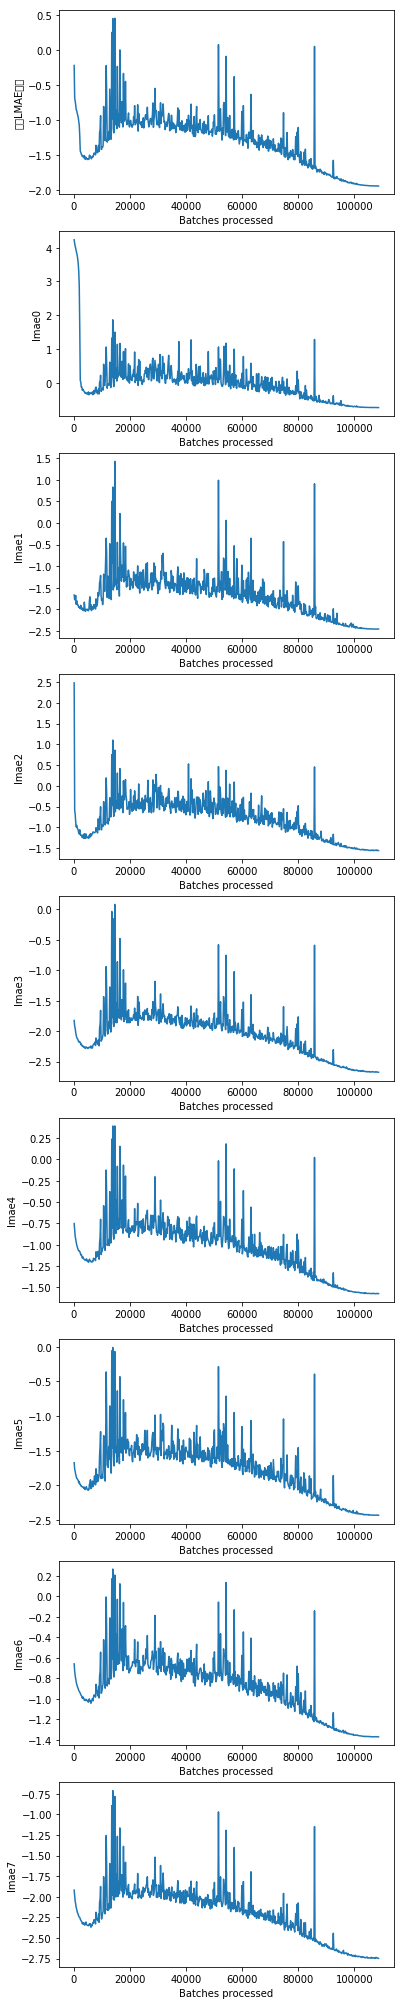

In [38]:
learner.recorder.plot_metrics()

Optional Fine tune regular fit 

In [ ]:
learner.callbacks.append(ReduceLROnPlateauCallback(learner, monitor='train_loss', mode='min', factor=0.2))

In [ ]:
learner.fit_one_cycle(300, 1e-2, moms=(0.75,0.70))

In [ ]:
learner.fit_one_cycle(100, 2e-2)#, moms=(0.75,0.70))

In [ ]:
learner.recorder.plot_lr(show_moms=True)

In [ ]:
learner.recorder.plot_losses()

In [ ]:
learner.recorder.plot_metrics()

In [ ]:
learner.fit(10,1e-4)

Validate

In [39]:
learner.to_fp32()
val = learner.validate()[1]
print(val)

tensor(-1.9417, device='cuda:0')


In [40]:
try:
    sub_fname = f'loss{learner.recorder.losses[-1]:.04f}val{val:.04f}'
except:
    sub_fname = f'val{val:.04f}'
learner.save(sub_fname)
print(sub_fname)

loss-3.9395val-1.9417


Inference

Make sure `tranforms` are activated to test set otherwise TTA > 1 will be as TTA =1

In [43]:
learner.data.train_dl.tfms

[]

In [44]:
TTA_N = 100

sub = defaultdict(int)
xt_ids_not_extended = (xt_ids!=0) & (xt_ids<=7163688)
ids = xt_ids[xt_ids_not_extended]

mb = master_bar(range(TTA_N))
for tta in mb:
    test_preds = np.zeros((0, 29), dtype=np.float32)

    for batch_idx, batch in progress_bar(
        enumerate(learner.dl(DatasetType.Test)), total=len(learner.dl(DatasetType.Test)), parent=mb):
        _, preds_,_,_,_,_,_ = learner.pred_batch(ds_type=DatasetType.Test, batch=batch)
        preds_ = preds_.sum(dim=1)
        test_preds = np.concatenate([test_preds, preds_.data.cpu().numpy()], axis = 0)

    preds = test_preds[xt_ids_not_extended]
    for k in range(len(ids)):
        sub[int(ids[k])] += preds[k]
    
for k in range(len(ids)):
    sub[int(ids[k])] = sub[int(ids[k])]/TTA_N

sub_df = pd.DataFrame(sub.items(), columns=['id', 'scalar_coupling_constant'])
sub_df.head()

,id,scalar_coupling_constant
0,4658147,17.352506
1,4658148,190.768073
2,4658149,6.093866
3,4658150,190.760597
4,4658151,17.343240


Submit to Kaggle

In [45]:
sub_df.to_csv(sub_fname, index=False)

In [46]:
comp = 'champs-scalar-coupling'

In [47]:
!kaggle competitions submit -c {comp} -f {sub_fname} -m 'rot 1-hot aug feat_reg 1e-3 coulomb tta {TTA_N} contribs multi-out {ext}'

100%|██████████████████████████████████████| 64.1M/64.1M [00:06<00:00, 9.70MB/s]
Successfully submitted to Predicting Molecular Properties

In [ ]:
import time
time.sleep(60)
!kaggle competitions submissions -c {comp} -v > submissions-{comp}.csv

In [ ]:
submissions = pd.read_csv(f'submissions-{comp}.csv')
submissions.iloc[0].publicScore